# Microbial analysis PART1
# Total Bacteria Abundance Statisical Analysis
____

* qPCR is performed fo quantification of total bacteria abundance;
* Samples included in the study: AirSample, AirDuct, Window, Saliva, Palm, and Blinds (Outside) for Regular room
* qPCR **LOD is 35 copies per uL**, which the Log of this concentration is approximately 1.544
* The Log copy number of genes (LogC) is for visualization and analysis
* Room Type variable: View is EC window patient rooms | Regular= Regular Window patient room
* For Time variable: T0 is baseline (before patient admission), T1 is first day of patient admission, T2 is second day of patient admission, and T3 is third day of patient admission


In [8]:
import numpy as np
from numpy.random import seed
from numpy.random import rand
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sys
from scipy import stats
from scipy.stats import levene
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats.mstats import kruskal
import scipy.spatial

In [9]:
from scipy.stats import f_oneway
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
from pingouin import welch_anova, read_dataset
from pingouin import kruskal, read_dataset
from pingouin import ttest
import pingouin as pg

### Import Data

In [5]:
df = None
# NanoDrop file
new_qPCR = pd.read_csv("/Users/ritalam519/Documents/GitHub/Microbial-analysis/Raw_data/qPCR_Data.csv",delimiter=",")
new_qPCR = new_qPCR.rename(columns={"Copy No.uL":"Copy_Number"})

In [6]:
new_qPCR.head(5) #there is an extra sample in RR4T0 which was not included in the study

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
0,RR1T1,1,AirSample,Regular,T1,1.544068,35.000
1,RR1T3,1,AirSample,Regular,T3,1.942307,87.560
2,RR2T1,2,AirSample,Regular,T1,1.727965,53.452
3,RR2T3,2,AirSample,Regular,T3,2.280807,190.900
4,RR3T1,3,AirSample,Regular,T1,2.050936,112.444


In [7]:
new_qPCR=new_qPCR.drop(new_qPCR.index[6])
new_qPCR.head(5)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
0,RR1T1,1,AirSample,Regular,T1,1.544068,35.000
1,RR1T3,1,AirSample,Regular,T3,1.942307,87.560
2,RR2T1,2,AirSample,Regular,T1,1.727965,53.452
3,RR2T3,2,AirSample,Regular,T3,2.280807,190.900
4,RR3T1,3,AirSample,Regular,T1,2.050936,112.444


 **LogC** means Log[Copy number of genes], which is the resutls used for analysis and graphing
 

## 1. Sample Process & Subgrouping

A function *subgroup* is defining for ease of analysis

In [136]:
def subgroup(data, field, val):
    return data.loc[data[field] == val]

In [137]:
#qPCR Subgroup based on the Sample type 
new_Blind =subgroup(new_qPCR,"Sample","Blinds")
new_Window = subgroup(new_qPCR,"Sample","Window")
new_AirDuct = subgroup(new_qPCR,"Sample","AirDuct")
new_AirSample = subgroup(new_qPCR,"Sample","AirSample")
new_Saliva = subgroup(new_qPCR,"Sample","Saliva")
new_Palm = subgroup(new_qPCR,"Sample","Palm")
new_AirSample.head(5)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
0,RR1T1,1,AirSample,Regular,T1,1.544068,35.000
1,RR1T3,1,AirSample,Regular,T3,1.942307,87.560
2,RR2T1,2,AirSample,Regular,T1,1.727965,53.452
3,RR2T3,2,AirSample,Regular,T3,2.280807,190.900
4,RR3T1,3,AirSample,Regular,T1,2.050936,112.444


### Subgrouping

**Window**

In [138]:
new_Window_T0 = subgroup(new_Window,"Time","T0")
new_Window_T1 = subgroup(new_Window,"Time","T1")
new_Window_T2 = subgroup(new_Window,"Time","T2")
new_Window_T3 = subgroup(new_Window,"Time","T3")
new_Window_T0.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
21,RR1T0,1,Window,Regular,T0,2.800744,632.039189
25,RR2T0,2,Window,Regular,T0,2.669652,467.360917
29,RR3T0,3,Window,Regular,T0,3.049488,1120.697405


In [139]:
#Subgroup Between Room Type to see the effect of Time
new_Window_R= subgroup(new_Window, "Room_Type","Regular")
new_Window_V= subgroup(new_Window, "Room_Type","View")
new_Window_R.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
21,RR1T0,1,Window,Regular,T0,2.800744,632.039189
22,RR1T1,1,Window,Regular,T1,3.127445,1341.050934
23,RR1T2,1,Window,Regular,T2,3.756068,5702.535401


**AirDuct**

In [140]:
new_AirDuct_T0 = subgroup(new_AirDuct,"Time","T0")
new_AirDuct_T1 = subgroup(new_AirDuct,"Time","T1")
new_AirDuct_T2 = subgroup(new_AirDuct,"Time","T2")
new_AirDuct_T3 = subgroup(new_AirDuct,"Time","T3")
new_AirDuct_T0.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
59,RR1T0,1,AirDuct,Regular,T0,3.355871,2269.192201
63,RR2T0,2,AirDuct,Regular,T0,3.911865,8163.289284
67,RR3T0,3,AirDuct,Regular,T0,4.043557,11054.956110


In [141]:
#Subgroup Between Room Type to see the effect of Time
new_AirDuct_R= subgroup(new_AirDuct, "Room_Type","Regular")
new_AirDuct_V= subgroup(new_AirDuct, "Room_Type","View")
new_AirDuct_R.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
59,RR1T0,1,AirDuct,Regular,T0,3.355871,2269.192201
60,RR1T1,1,AirDuct,Regular,T1,2.795706,624.750030
61,RR1T2,1,AirDuct,Regular,T2,3.612296,4095.396392


**Air Sample**

In [142]:
new_AirSample_T1 = subgroup(new_AirSample,"Time","T1")
new_AirSample_T3 = subgroup(new_AirSample,"Time","T3")
new_AirSample_T3.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
1,RR1T3,1,AirSample,Regular,T3,1.942307,87.560
3,RR2T3,2,AirSample,Regular,T3,2.280807,190.900
5,RR3T3,3,AirSample,Regular,T3,1.888357,77.332


In [143]:
#subgroup between Room 
new_AirSample_R=subgroup(new_AirSample, "Room_Type","Regular")
new_AirSample_V=subgroup(new_AirSample, "Room_Type","View")
new_AirSample_V.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
11,WR1T1,1,AirSample,View,T1,2.417050,261.246
12,WR1T3,1,AirSample,View,T3,2.334914,216.229
13,WR3T1,3,AirSample,View,T1,2.820762,661.854


**Saliva**

In [144]:
new_Saliva_T1 = subgroup(new_Saliva,"Time","T1")
new_Saliva_T3 = subgroup(new_Saliva,"Time","T3")
new_Saliva_T3.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
141,RR1T3,1,Saliva,Regular,T3,7.441391,2.763067e+07
143,RR2T3,2,Saliva,Regular,T3,7.919613,8.310236e+07
145,RR3T3,3,Saliva,Regular,T3,8.457771,2.869267e+08


In [145]:
#subgroup between Room 
new_Saliva_R=subgroup(new_Saliva, "Room_Type","Regular")
new_Saliva_V=subgroup(new_Saliva, "Room_Type","View")
new_Saliva_V.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
150,WR1T1,1,Saliva,View,T1,6.069071,1.172386e+06
151,WR1T3,1,Saliva,View,T3,7.388945,2.448754e+07
152,WR3T1,3,Saliva,View,T1,8.785558,6.103203e+08


**Palm**

In [146]:
new_Palm_T1 = subgroup(new_Palm,"Time","T1")
new_Palm_T3 = subgroup(new_Palm,"Time","T3")
new_Palm_T3.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
121,RR1T3,1,Palm,Regular,T3,3.080013,1202.300979
123,RR2T3,2,Palm,Regular,T3,2.890964,777.971405
125,RR3T3,3,Palm,Regular,T3,2.425129,266.151835


In [147]:
#subgroup between Room 
new_Palm_R=subgroup(new_Palm, "Room_Type","Regular")
new_Palm_V=subgroup(new_Palm, "Room_Type","View")
new_Palm_V.head(3)

,PID,Room_Number,Sample,Room_Type,Time,LogC,Copy_Number
130,WR1T1,1,Palm,View,T1,3.623007,4197.657807
131,WR1T3,1,Palm,View,T3,3.340345,2189.499256
132,WR3T1,3,Palm,View,T1,4.131513,13536.697440


#### Intial data visualization

(0.0, 12.0)

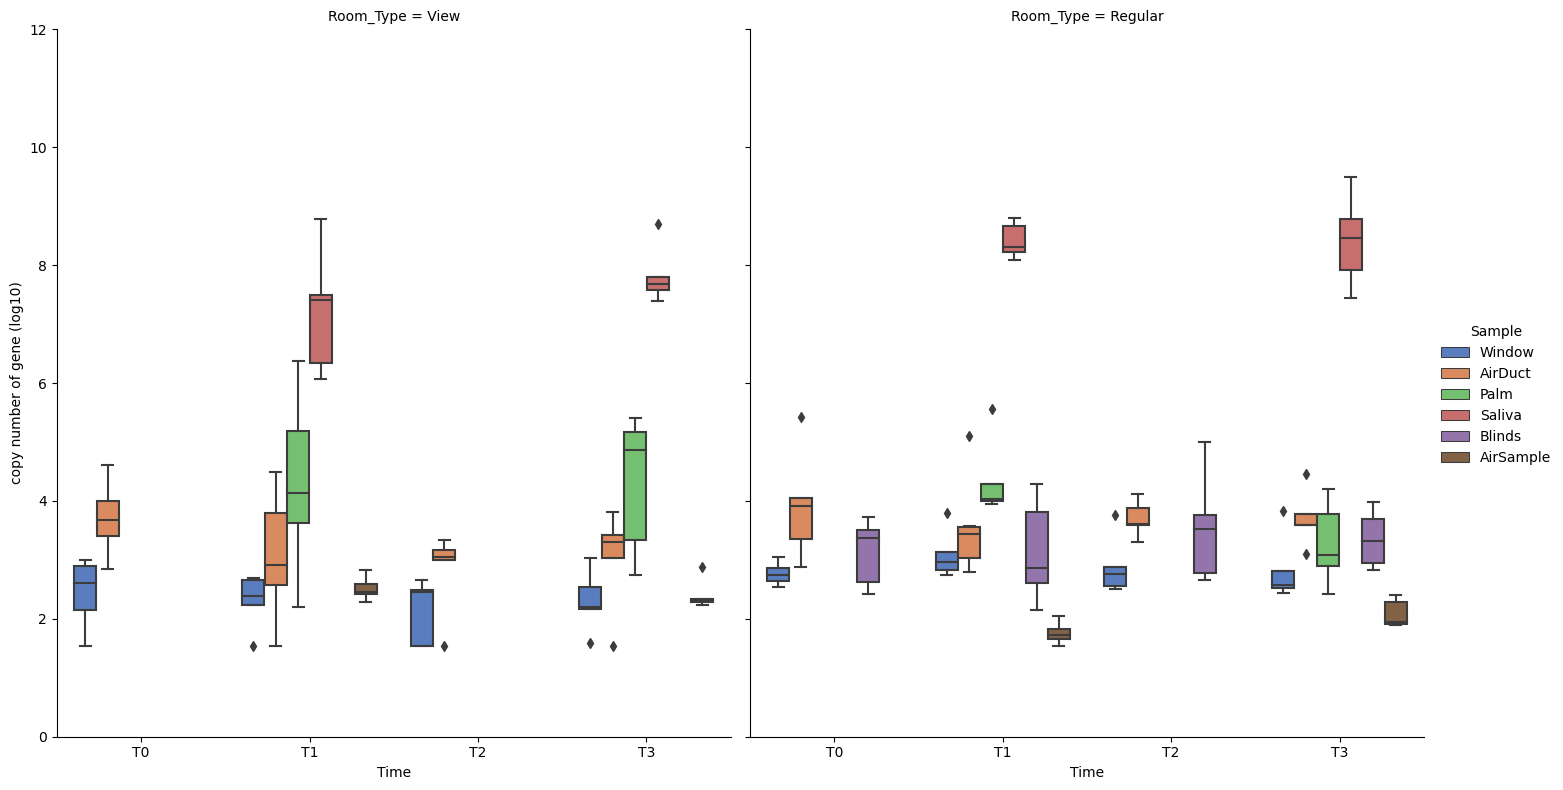

In [210]:
#Overview with timepoint
g = sns.catplot(x="Time", y="LogC",
                hue="Sample", hue_order=['Window','AirDuct','Palm','Saliva','Blinds','AirSample'],
                col='Room_Type',col_order=['View','Regular'],order=['T0','T1','T2','T3'],
                col_wrap=2, palette='muted',
                data=new_qPCR, kind="box", dodge=True,
                height=8, aspect=.9);
g.set(ylabel='copy number of gene (log10)')

plt.ylim(0,12)

____

#  2. Statistical analysis 

## Effects of indoor daylight (room-type variable) at each time point
 * **Two sample t-test** between Regular and EC window room (View) at each Timepoint if data is normally distributed and variance is homogenous 
 * **Man-Whitnney U Test** if data is NOT normally distributed or variance test failed
 
## Effects of occupancy (Time variable) in Regular and EC window Room
 * **One way repeated ANOVA** is used for comparison of results from baseline(T0) to T3 (3rd day of patients admission) if data is normally distributed within the same type of room. This considered the blocked design as it is a repeated measurement
 * **Fried man test** is used if data is NOT normally distributed or variance test failed
 
___

ANOVA assumptions includes **1) normal distribution and 2)homogenity of variance**

 
### Normalty assessment ###

**Shapiro Wilk Test** is used for assessing the normality of dataset. If P>0.05, we failed the reject null hypothesis hence data followed normal distribution.

### Variance assumption ###

Either **Leven's test or bartlett test** can be used for assessing the variance. If P>0.05, we failed the reject null hypothesis and data have homogenous of variance.
___

## Window Sample

In [213]:
#Set color palette
palette = {"View":"#95d0fc",
           "Regular":"#ffa756"}
palette2= {"View":"white",
           "Regular":"white"}
color1= {"View":"#a2cffe",
           "Regular":"#d8dcd6"}
color2= {"View":"#75bbfd",
           "Regular":"#929591"}

<Figure size 800x600 with 0 Axes>

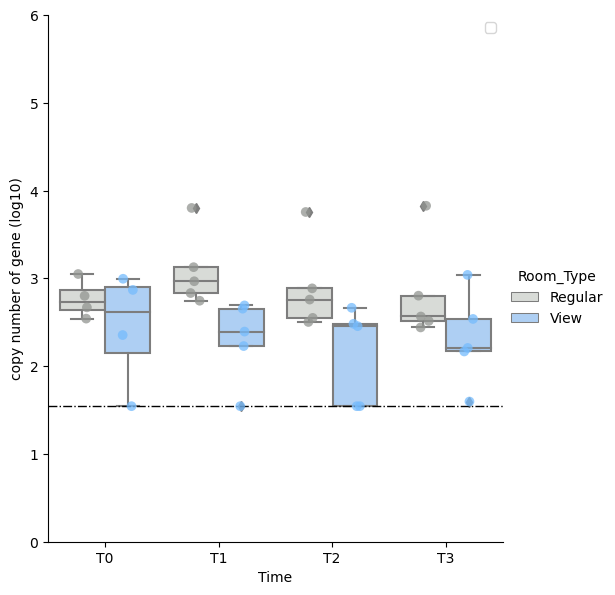

<Figure size 800x600 with 0 Axes>

In [221]:
ax=sns.catplot(x="Time", y="LogC",
            hue="Room_Type", order=['T0','T1','T2','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=0.9,
            palette=color1, data=new_Window)
ax = sns.stripplot(x='Time', y='LogC', hue='Room_Type',order=['T0','T1','T2','T3'],
                   hue_order=('Regular','View',), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=new_Window)

handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="copy number of gene (log10)")
plt.ylim(0,6)
plt.axhline(y=1.544068,color="black",linestyle='-.', linewidth=1) # This is the qPCR LOD
plt.figure(figsize= (8,6))

**Normality assessment**

In [148]:
# Normality of Window Dataframe for each Timepoints
stat, p =  shapiro(new_Window["LogC"])
print("P-value of shapiro wilk test for Window  is:", p)

P-value of shapiro wilk test for Window  is: 0.013288493268191814


In [149]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=new_Window, dv='LogC', group='Time')

,W,pval,normal
T0,0.839259,0.074012,True
T1,0.961205,0.799516,True
T2,0.887170,0.157541,True
T3,0.938673,0.538343,True


In [150]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=new_Window, dv='LogC', group='Room_Type')

,W,pval,normal
Regular,0.814062,0.001843,False
View,0.893850,0.037706,False


In [151]:
#Transformation of dataframe using boxcos 
new_Window_bx,fitted_lambda =stats.boxcox(new_Window_R['LogC'])
stat, p = shapiro(new_Window_bx)
print('Shapiro statistics of transformed Window in Regular Room 0=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of transformed Window in Regular Room 0=0.947, p=0.347


In [152]:
#Transformation of dataframe using boxcos 
new_Window_bx,fitted_lambda =stats.boxcox(new_Window_V['LogC'])
stat, p = shapiro(new_Window_bx)
print('Shapiro statistics of transformed Window in EC Window Room 0=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of transformed Window in EC Window Room 0=0.914, p=0.089


* Data at individual timepoint is normally distributed
* Regular and EC window room are also indivudally normally distributed after boxcox transformation

**Variance assessment**

In [153]:
#Variance
stat, p =  levene(new_Window_R["LogC"], new_Window_V["LogC"])
print("P-value of levene test for Window Regular and EC Window room is:", p)
stat, p =  levene(new_Window_T0["LogC"], new_Window_T1["LogC"],new_Window_T2["LogC"],new_Window_T3["LogC"] )
print("P-value of levene test for Window between time is:", p)

P-value of levene test for Window Regular and EC Window room is: 0.3464576619245988
P-value of levene test for Window between time is: 0.9786949329608553


* The entire Window dataset is NOT normally distributed, though at individual time point it is

* Variance is homogenmous between timepoints and room type


### Statistical Test: effect of Indoor daylight on total bacteria abundance on WINDOW

In [154]:
#Subgroup for each Timepoint 
new_Window_T1_R=subgroup(new_Window_T1, "Room_Type","Regular")
new_Window_T1_V=subgroup(new_Window_T1, "Room_Type","View")
new_Window_T2_R=subgroup(new_Window_T2, "Room_Type","Regular")
new_Window_T2_V=subgroup(new_Window_T2, "Room_Type","View")
new_Window_T0_R=subgroup(new_Window_T0, "Room_Type","Regular")
new_Window_T0_V=subgroup(new_Window_T0, "Room_Type","View")
new_Window_T3_R=subgroup(new_Window_T3, "Room_Type","Regular")
new_Window_T3_V=subgroup(new_Window_T3, "Room_Type","View")

In [155]:
# One way ANOVA between Room Type
res=ttest(new_Window_T0_R['LogC'], new_Window_T0_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.936464,6,two-sided,0.385179,"[-0.52, 1.17]",0.66218,0.673,0.124885


In [156]:
# One way ANOVA between Room Type
res=ttest(new_Window_T1_R['LogC'], new_Window_T1_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.824505,8,two-sided,0.022338,"[0.15, 1.44]",1.786374,3.07,0.697276


In [157]:
# One way ANOVA between Room Type
res=ttest(new_Window_T2_R['LogC'], new_Window_T2_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.251178,8,two-sided,0.054467,"[-0.02, 1.52]",1.42377,1.768,0.507729


In [158]:
# One way ANOVA between Room Type
res=ttest(new_Window_T3_R['LogC'], new_Window_T3_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.490529,8,two-sided,0.17442,"[-0.28, 1.33]",0.942693,0.923,0.260065


In [159]:
#Window T0 MannWhitney U test
scipy.stats.mannwhitneyu(new_Window_T0_R['LogC'],new_Window_T0_V['LogC'], alternative='two-sided')

MannwhitneyuResult(statistic=10.0, pvalue=0.6857142857142857)

In [160]:
#Window T1 MannWhitney U test
scipy.stats.mannwhitneyu(new_Window_T1_R['LogC'],new_Window_T1_V['LogC'], alternative='two-sided')

MannwhitneyuResult(statistic=25.0, pvalue=0.007936507936507936)

In [161]:
#Window T2 MannWhitney U test
scipy.stats.mannwhitneyu(new_Window_T2_R['LogC'],new_Window_T2_V['LogC'], alternative='two-sided')

MannwhitneyuResult(statistic=23.0, pvalue=0.03614514204656228)

In [162]:
#Window T3 MannWhitney U test
scipy.stats.mannwhitneyu(new_Window_T3_R['LogC'],new_Window_T3_V['LogC'], alternative='two-sided')

MannwhitneyuResult(statistic=19.0, pvalue=0.2222222222222222)

### Statistical test: effect of occupancy on total bacteria abundance on Window ###

In [163]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=new_Window_R, dv="LogC", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.075,3,0.9,0.825428


In [164]:
# Try repeated One Way ANOVA
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_Window_R)
print(aov)

  Source  ddof1  ddof2         F    p-unc       np2       eps
0   Time      3      9  0.421745  0.74199  0.123254  0.565376


In [165]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=new_Window_V, dv="LogC", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.075,3,0.9,0.825428


In [166]:
# Try repeated One Way ANOVA
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_Window_V)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2       eps
0   Time      3      9  0.159898  0.920632  0.050602  0.524855


___
## Air Sample 

**Initial visualization**

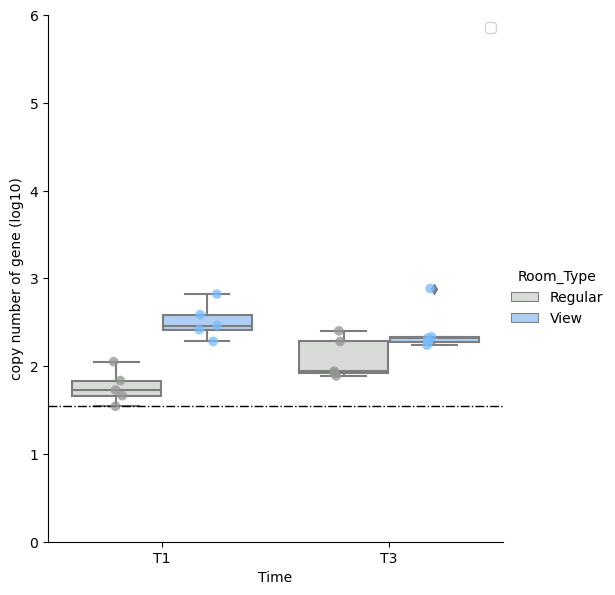

In [224]:
#AirSample
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="LogC",
            hue="Room_Type", order=['T1','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=new_AirSample)
ax = sns.stripplot(x='Time', y='LogC', hue='Room_Type',order=['T1','T3'],
                   hue_order=('Regular','View',), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=new_AirSample)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="copy number of gene (log10)")
plt.ylim(0,6)
plt.axhline(y=1.544068,color="black",linestyle='-.', linewidth=1)

#### Normality assessment ####

In [168]:
stat, p =  shapiro(new_AirSample["LogC"])
print("P-value of shapiro wilk test for AirSample  is:", p)

P-value of shapiro wilk test for AirSample  is: 0.7132822871208191


In [169]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=new_AirSample, dv='LogC', group='Time')

,W,pval,normal
T1,0.946085,0.622474,True
T3,0.877615,0.122503,True


In [170]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=new_AirSample, dv='LogC', group='Room_Type')

,W,pval,normal
Regular,0.959794,0.783524,True
View,0.844712,0.050240,True


* Air Sample datasets are all normally distributed *

#### Variance test ####

In [171]:
#Variance
stat, p =  levene(new_AirSample_R["LogC"], new_AirSample_V["LogC"])
print("P-value of levene test for AirSample Regular and EC Window room is:", p)
stat, p =  levene(new_AirSample_T1["LogC"],new_AirSample_T3["LogC"] )
print("P-value of levene test for Air Sample between time is:", p)

P-value of levene test for AirSample Regular and EC Window room is: 0.7816165883413314
P-value of levene test for Air Sample between time is: 0.06065687825016659


____
#### Statistical test: Effect of indoor daylight on **Air Sample** microbiome ###

In [172]:
#Subgroup for each Time point
new_AirSample_T1_R=subgroup(new_AirSample_T1, "Room_Type","Regular")
new_AirSample_T1_V=subgroup(new_AirSample_T1, "Room_Type","View")
new_AirSample_T3_R=subgroup(new_AirSample_T3, "Room_Type","Regular")
new_AirSample_T3_V=subgroup(new_AirSample_T3, "Room_Type","View")

In [173]:
#2 sample t-test ANOVA for Air Sample
#At Time 1 between Two Room Type
res=ttest(new_AirSample_T1_R['LogC'], new_AirSample_T1_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.99172,8,two-sided,0.000326,"[-1.04, -0.46]",3.789497,64.802,0.999356


In [174]:
#2 sample t-test ANOVA for Air Sample
#At Time 1 between Two Room Type
res=ttest(new_AirSample_T3_R['LogC'], new_AirSample_T3_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.02804,8,two-sided,0.077091,"[-0.69, 0.04]",1.282645,1.442,0.430625


#### Statistical test: Effect of occupancy (Time) on **Air Sample** microbiome ###

In [175]:
#View Room IS normally distributed, so One-Ways Repeated ANOVA on AirSample
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_AirSample_R)
print(aov)

  Source  ddof1  ddof2         F    p-unc       np2  eps
0   Time      1      4  3.953018  0.11769  0.497046  1.0


In [176]:
#View Room IS normally distributed, so One-Ways Repeated ANOVA on AirSample
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_AirSample_V)
print(aov)

  Source  ddof1  ddof2        F     p-unc       np2  eps
0   Time      1      4  2.78021  0.170762  0.410048  1.0


___
### AirDuct ###

**Initial data visualization**

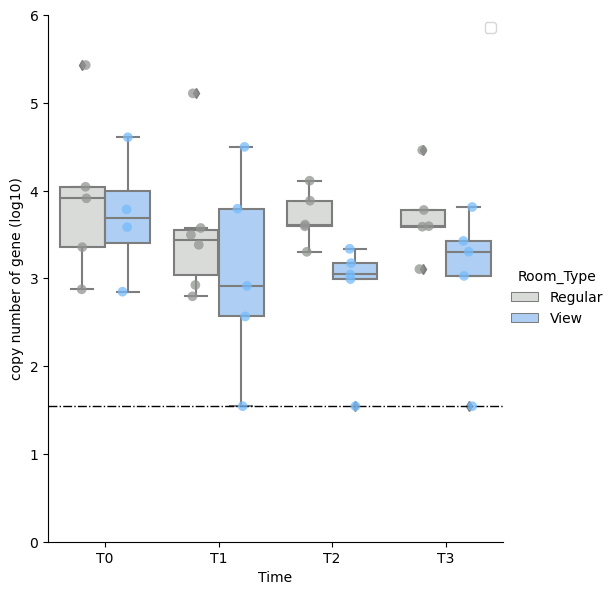

In [223]:
#Another Version
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="LogC",
            hue="Room_Type", order=['T0','T1','T2','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=new_AirDuct)
ax = sns.stripplot(x='Time', y='LogC', hue='Room_Type',order=['T0','T1','T2','T3'],
                   hue_order=('Regular','View',), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=new_AirDuct)
# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="copy number of gene (log10)")
plt.ylim(0,6)
plt.axhline(y=1.544068,color="black",linestyle='-.', linewidth=1)

#### Normality assessment

In [177]:
stat, p =  shapiro(new_AirDuct["LogC"])
print("P-value of shapiro wilk test for AirDuct Sample  is:", p)

P-value of shapiro wilk test for AirDuct Sample  is: 0.05195183679461479


In [178]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=new_AirDuct, dv='LogC', group='Time')

,W,pval,normal
T0,0.940261,0.584651,True
T1,0.973093,0.915931,True
T2,0.851212,0.060049,True
T3,0.866271,0.090423,True


In [179]:
# Normality of AirDuct Dataframe for each Room Type
pg.normality(data=new_AirDuct, dv='LogC', group='Room_Type')

,W,pval,normal
Regular,0.905320,0.044427,False
View,0.923234,0.129879,True


#### Variance Analysis 

In [180]:
#Variance
stat, p =  levene(new_AirDuct_R["LogC"], new_AirDuct_V["LogC"])
print("P-value of levene test for AirDuct Regular and EC Window room is:", p)
stat, p =  levene(new_AirDuct_T0["LogC"], new_AirDuct_T1["LogC"],new_AirDuct_T2["LogC"],new_AirDuct_T3["LogC"] )
print("P-value of levene test for AirDuct between time is:", p)

P-value of levene test for AirDuct Regular and EC Window room is: 0.2851615166127224
P-value of levene test for AirDuct between time is: 0.7319067968469165


* Air Duct regular room is NOT normally distributed 

#### Statistical test: Effect of occupancy (Time) on **Air Duct** microbiome ###


In [181]:
#Subgroup for each Time point
new_AirDuct_T1_R=subgroup(new_AirDuct_T1, "Room_Type","Regular")
new_AirDuct_T1_V=subgroup(new_AirDuct_T1, "Room_Type","View")
new_AirDuct_T2_R=subgroup(new_AirDuct_T2, "Room_Type","Regular")
new_AirDuct_T2_V=subgroup(new_AirDuct_T2, "Room_Type","View")
new_AirDuct_T0_R=subgroup(new_AirDuct_T0, "Room_Type","Regular")
new_AirDuct_T0_V=subgroup(new_AirDuct_T0, "Room_Type","View")
new_AirDuct_T3_R=subgroup(new_AirDuct_T3, "Room_Type","Regular")
new_AirDuct_T3_V=subgroup(new_AirDuct_T3, "Room_Type","View")

In [182]:
###Two sample T-test at baseline (T0)
res=ttest(new_AirDuct_T0_R['LogC'], new_AirDuct_T0_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.385982,6.993878,two-sided,0.710982,"[-1.11, 1.55]",0.249981,0.532,0.06215


In [183]:
###Two sample T-test at T1
res=ttest(new_AirDuct_T1_R['LogC'], new_AirDuct_T1_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.792217,7.186763,two-sided,0.453586,"[-0.95, 1.92]",0.494925,0.584,0.113502


In [184]:
###Two sample T-test at T2
res=ttest(new_AirDuct_T2_R['LogC'], new_AirDuct_T2_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.506938,8,two-sided,0.036545,"[0.07, 1.7]",1.585527,2.252,0.595412


In [185]:
###Two sample T-test at T3
res=ttest(new_AirDuct_T3_R['LogC'], new_AirDuct_T3_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.52383,8,two-sided,0.166056,"[-0.35, 1.72]",0.963754,0.946,0.269556


#### Statistical test: Effect of occupancy (Time) on **Air Duct** microbiome ###

In [186]:
#Regular Room is NOT normally distributedm, Friedman Test to see the block effect of TIME
res= pg.friedman(data=new_AirDuct_R, dv="LogC", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.575,3,6.9,0.075154


In [187]:
#One-Ways Repeated ANOVA on Air Duct EC Window room
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_AirDuct_V)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2       eps
0   Time      3      9  0.854422  0.498738  0.221673  0.508278


___
### Palm ###

**Initial data visualization**

(0.0, 12.0)

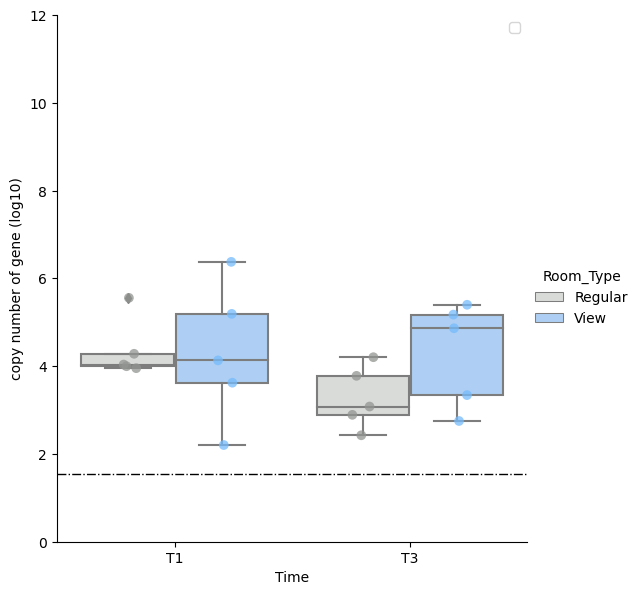

In [225]:
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="LogC",
            hue="Room_Type", order=['T1','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=new_Palm)
ax = sns.stripplot(x='Time', y='LogC', hue='Room_Type',order=['T1','T3'],
                   hue_order=('Regular','View',), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=new_Palm)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="copy number of gene (log10)")
plt.axhline(y=1.544068,color="black",linestyle='-.', linewidth=1)
plt.ylim(0,12)

#### Normality test

In [189]:
stat, p =  shapiro(new_Palm["LogC"])
print("P-value of shapiro wilk test for Palm Sample  is:", p)

P-value of shapiro wilk test for Palm Sample  is: 0.880913496017456


In [190]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=new_Palm, dv='LogC', group='Room_Type')

,W,pval,normal
Regular,0.935871,0.508053,True
View,0.966012,0.851607,True


#### Variance Test ####

In [191]:
#Variance
stat, p =  levene(new_Palm_R["LogC"], new_Palm_V["LogC"])
print("P-value of levene test for palm Regular and EC Window room is:", p)
stat, p =  levene(new_Palm_T1["LogC"],new_Palm_T3["LogC"] )
print("P-value of levene test for Palm between time is:", p)

P-value of levene test for palm Regular and EC Window room is: 0.09989426160438675
P-value of levene test for Palm between time is: 0.7114309369290224


* Palm dataset passed both normality and variance assumption *

#### Statistical test: Effect of occupancy (Time) on **Palm** microbiome ###

In [192]:
new_Palm_T1_R=subgroup(new_Palm_T1, "Room_Type","Regular")
new_Palm_T1_V=subgroup(new_Palm_T1, "Room_Type","View")
new_Palm_T3_R=subgroup(new_Palm_T3, "Room_Type","Regular")
new_Palm_T3_V=subgroup(new_Palm_T3, "Room_Type","View")

In [193]:
###Two sample T-test
res=ttest(new_Palm_T1_R['LogC'], new_Palm_T1_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.078476,8,two-sided,0.939377,"[-1.71, 1.83]",0.049632,0.493,0.050554


In [194]:
###Two sample T-test
res=ttest(new_Palm_T3_R['LogC'], new_Palm_T3_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.666589,8,two-sided,0.134156,"[-2.45, 0.4]",1.054044,1.059,0.312147


#### Statistical test: Effect of occupancy (Time) on **Palm** microbiome ###

In [195]:
#One-Ways Repeated ANOVA 
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_Palm_R)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2  eps
0   Time      1      4  3.917803  0.118891  0.494809  1.0


In [196]:
#One-Ways Repeated ANOVA 
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_Palm_V)
print(aov)

  Source  ddof1  ddof2             F     p-unc           np2  eps
0   Time      1      4  3.024675e-07  0.999588  7.561687e-08  1.0


___
### SALIVA ###

**Initial data visualization**

(0.0, 12.0)

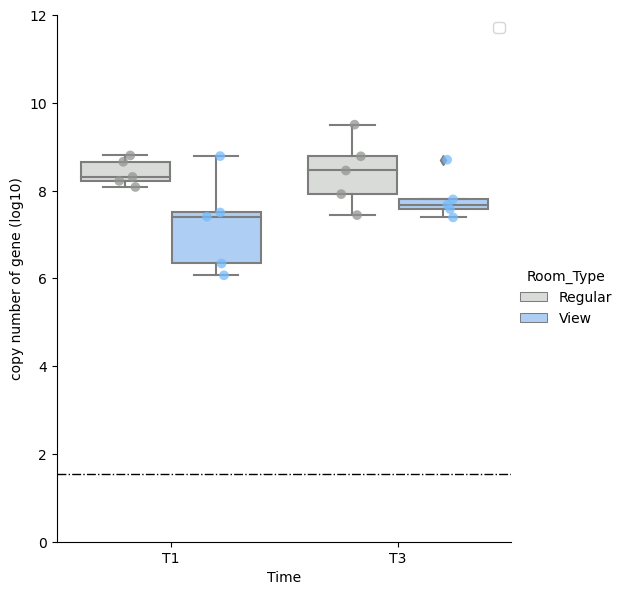

In [226]:
#Saliva
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="LogC",
            hue="Room_Type", order=['T1','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=new_Saliva)
ax = sns.stripplot(x='Time', y='LogC', hue='Room_Type',order=['T1','T3'],
                   hue_order=('Regular','View',), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=new_Saliva)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="copy number of gene (log10)")
plt.axhline(y=1.544068,color="black",linestyle='-.', linewidth=1)
plt.ylim(0,12)

In [ ]:
**Normality Test**

In [197]:
stat, p =  shapiro(new_Saliva["LogC"])
print("P-value of shapiro wilk test for Saliva Sample  is:", p)

P-value of shapiro wilk test for Saliva Sample  is: 0.3795774281024933


In [198]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=new_Saliva, dv='LogC', group='Room_Type')

,W,pval,normal
Regular,0.982539,0.977296,True
View,0.912496,0.298578,True


In [199]:
# Normality of Window Dataframe for each Room Type
pg.normality(data=new_Saliva, dv='LogC', group='Time')

,W,pval,normal
T1,0.876811,0.119914,True
T3,0.898822,0.212655,True


**Variance test**

In [200]:
#Variance
stat, p =  levene(new_Saliva_R["LogC"], new_Saliva_V["LogC"])
print("P-value of levene test for saliva Regular and EC Window room is:", p)
stat, p =  levene(new_Saliva_T1["LogC"],new_Saliva_T3["LogC"] )
print("P-value of levene test for saliva between time is:", p)

P-value of levene test for saliva Regular and EC Window room is: 0.4687473968323175
P-value of levene test for saliva between time is: 0.48374157870577217


* Saliva dataset passed both normality and variance assumption

#### Statistical test: Effect of occupancy (Time) on **Saliva** microbiome ###

In [201]:
new_Saliva_T1_R=subgroup(new_Saliva_T1, "Room_Type","Regular")
new_Saliva_T1_V=subgroup(new_Saliva_T1, "Room_Type","View")
new_Saliva_T3_R=subgroup(new_Saliva_T3, "Room_Type","Regular")
new_Saliva_T3_V=subgroup(new_Saliva_T3, "Room_Type","View")

In [202]:
###Two sample T-test
res=ttest(new_Saliva_T1_R['LogC'], new_Saliva_T1_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.382397,8,two-sided,0.044379,"[0.04, 2.35]",1.50676,2.0,0.553058


In [203]:
###Two sample T-test
res=ttest(new_Saliva_T3_R['LogC'], new_Saliva_T3_V['LogC'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.400775,8,two-sided,0.198856,"[-0.38, 1.56]",0.885928,0.863,0.235393


In [204]:
#One-Ways Repeated ANOVA for regular room
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_Saliva_R)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2  eps
0   Time      1      4  0.000429  0.984474  0.000107  1.0


In [205]:
#One-Ways Repeated ANOVA EC Window Room
aov = pg.rm_anova(dv='LogC', within=['Time'], subject='Room_Number', data=new_Saliva_V)
print(aov)

  Source  ddof1  ddof2        F     p-unc       np2  eps
0   Time      1      4  3.57814  0.131508  0.472166  1.0
